In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from typing import Dict
from pyimzml.ImzMLParser import ImzMLParser
from utils import read_msi
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from chip_types_data_analysis import spectra_significant_features_threshold

sns.set_context("notebook", font_scale=1.25)

# Define current folder using this file
CWD = Path(".")
# Define folder that contains the dhg dataset
OPTIMIZATION_PATH = Path(os.path.join(CWD, "..", "data", "OPTIMIZATION"))
# Define folder that contains raw data
RAW_DATA = OPTIMIZATION_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = OPTIMIZATION_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = OPTIMIZATION_PATH.joinpath("processed")
# Define file that contains dhg metadata
METADATA_PATH = OPTIMIZATION_PATH.joinpath("metadata.csv")
# Define mass range start value
MZ_START = 50
# Define mass range end value
MZ_END = 1200
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define lock mass reference peak
LOCK_MASS_PEAK = 885.5498
# Define lock mass tol
LOCK_MASK_TOL = 0.3
# Define representative peaks
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]
# Define number of features thresholds
THRESHOLDS = [0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.3, 0.4]
# Define random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
# Define path to save figures
PLOT_PATH = CWD / "optimization"
# Create dirs
PLOT_PATH.mkdir(parents=True, exist_ok=True)

In [7]:
def mean_number_of_features(metadata_df):
  number_of_features = {}

  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    common_representation_path = os.path.join(
        PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
    )
    with ImzMLParser(common_representation_path) as p:
      # Read MSI data and get the intensity matrix
      _, msi = read_msi(p)
      #
      mean_spectra = np.mean(msi, axis=(0, 1))
      #
      number_of_features[roi.file_name] = {}
      for threshold in THRESHOLDS:
        number_of_features[roi.file_name
                          ][threshold] = spectra_significant_features_threshold(
                              mean_spectra, threshold
                          )
  return number_of_features


def spectra_wise_number_of_features(metadata_df):
  number_of_features = {}

  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    common_representation_path = os.path.join(
        PROCESSED_DATA, f"{roi.sample_file_name}", "common_representation.imzML"
    )
    with ImzMLParser(common_representation_path) as p:
      _, msi = read_msi(p)
      #
      number_of_features[roi.file_name] = {}
      for threshold in THRESHOLDS:
        msi_num_features = []
        for i, j in np.ndindex(msi.shape[:2]):
          spectra = msi[i, j, :]
          msi_num_features.append(
              spectra_significant_features_threshold(spectra, threshold)
          )
        number_of_features[roi.file_name][threshold] = np.mean(
            msi_num_features
        ), np.std(msi_num_features)
  return number_of_features


def plot_optimization_parameters(
    df, save_path, std_df=None,
    parameters=["MeOH", "voltage", "ssd", "sid", "angle"]
):
  fig, axes = plt.subplots(
      nrows=len(parameters), ncols=1, figsize=(12, len(parameters) * 5),
      sharex=False
  )
  fig.subplots_adjust(hspace=0.5)

  for ax, optimization_parameter in zip(axes, parameters):
    cols = df.columns.map(lambda col: optimization_parameter in col)
    cols_names = [col.split("_")[-1] for col in df.columns[cols]]

    mean_values = df.loc[:, cols].T
    sns.lineplot(mean_values, ax=ax)

    if std_df is not None:
      std_values = std_df.loc[:, cols].T
      for i, col in enumerate(mean_values.columns):
        ax.fill_between(
            range(mean_values.shape[0]), mean_values[col] - std_values[col],
            mean_values[col] + std_values[col], alpha=0.2
        )

    ax.set_xticks(range(len(cols_names)))
    ax.set_xticklabels(cols_names)
    ax.set_title(optimization_parameter.capitalize())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(title="Thresholds", loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()
  plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
  plt.show()

def plot_number_of_features_heatmap(df, threshold, save_path):
    cols = df.columns.map(lambda col: "pressure_flow_rate" in col)
    series = df.loc[threshold, cols]
    
    # Extracting the unique pressures and flow rates
    pressures = sorted(set(int(key.split('_')[-1].split('-')[0]) for key in series.index))
    flow_rates = sorted(set(float(key.split('-')[1]) for key in series.index))
    
    # Creating a DataFrame for the heatmap
    heatmap_data = pd.DataFrame(index=pressures, columns=flow_rates)
    
    # Populating the DataFrame with the data
    for key, value in series.items():
        pressure, flow_rate = key.split('_')[-1].split('-')
        heatmap_data.at[int(pressure), float(flow_rate)] = value
    
    # Converting the DataFrame to numpy array for plotting
    heatmap_data = heatmap_data.astype(float).to_numpy()
    
    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(heatmap_data, aspect='auto', cmap='magma', origin='lower')
    plt.colorbar(label='Number of features')
    plt.xticks(ticks=np.arange(len(flow_rates)), labels=flow_rates)
    plt.yticks(ticks=np.arange(len(pressures)), labels=pressures)
    plt.xlabel('Flow Rate [μL/min]')
    plt.ylabel('Pressure [bar]')
    plt.title('Heatmap of Number of Features')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
    plt.show()
  
def mean_tic(metadata_df):
  sample_tics = {}
  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    #
    raw_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
    #
    with ImzMLParser(raw_path) as reader:
      intensities = {}
      # Loop over each spectra in MSI
      for idx, _ in enumerate(reader.coordinates):
        raw_mzs, raw_intensities = reader.getspectrum(idx)
        for mz, intensity in zip(raw_mzs, raw_intensities):
          temp_intensities = intensities.get(mz, [])
          temp_intensities.append(intensity)
          intensities[mz] = temp_intensities
      sample_tics[roi.file_name] = np.array([np.mean(intensities[mz]) for mz in intensities.keys()]).sum()
  return sample_tics

def spectra_wise_tic(metadata_df):
  sample_tics = {}
  for _, roi in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    #
    raw_path = os.path.join(ALIGNED_DATA, f"{roi.file_name}.imzML")
    #
    with ImzMLParser(raw_path) as reader:
      tics = []
      # Loop over each spectra in MSI
      for idx, _ in enumerate(reader.coordinates):
        _, raw_intensities = reader.getspectrum(idx)
        tics.append(raw_intensities.sum())

      sample_tics[roi.file_name] = {
          'mean': np.mean(tics),
          'std': np.std(tics)
      }
  return sample_tics

def plot_optimization_parameters_tic(spectra_mean_df, save_path, spectra_std_df=None, optimization_parameters=["MeOH", "voltage", "ssd", "sid", "angle"]):
        
    fig, axes = plt.subplots(len(optimization_parameters), 1, figsize=(10, 20))

    for optimization_parameter, ax in zip(optimization_parameters, axes.flatten()):
        cols = spectra_mean_df.columns.map(lambda col: optimization_parameter in col)
        cols_names = [col.split("_")[-1] for col in spectra_mean_df.columns[cols]]

        means = spectra_mean_df.loc[:, cols].values.flatten()
        
        sns.lineplot(x=range(len(cols_names)), y=means, ax=ax, color="tab:red")
        
        if spectra_std_df is not None:
            stds = spectra_std_df.loc[:, cols].values.flatten()
            ax.errorbar(x=range(len(cols_names)), y=means, yerr=stds, fmt='o', capsize=5, color="tab:red")
        
        ax.set_xticks(range(len(cols_names)))
        ax.set_xticklabels(cols_names)
        ax.set_title(optimization_parameter.capitalize())

        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
    plt.show()


# Read metadata
metadata_df = pd.read_csv(METADATA_PATH)
# Define map from file to sample_file
file_to_sample_file_map = pd.Series(
    metadata_df.sample_file_name.values, index=metadata_df.file_name
).to_dict()


# Get mean number of features and save it
mean_number_of_features_df = pd.DataFrame(mean_number_of_features(metadata_df))
mean_number_of_features_df.to_csv(
    PLOT_PATH / "mean_spectra_number_of_features.csv"
)
mean_number_of_features_df.columns = mean_number_of_features_df.columns.map(
    file_to_sample_file_map.get
)

# Get spectra wise number of features and save it
spectra_wise_number_of_features_numpy = spectra_wise_number_of_features(
    metadata_df
)
spectra_wise_number_of_features_mean_df = pd.DataFrame(
    {
        key: {sub_key: sub_value[0]
              for sub_key, sub_value in value.items()}
        for key, value in spectra_wise_number_of_features_numpy.items()
    }
)
spectra_wise_number_of_features_std_df = pd.DataFrame(
    {
        key: {sub_key: sub_value[1]
              for sub_key, sub_value in value.items()}
        for key, value in spectra_wise_number_of_features_numpy.items()
    }
)
spectra_wise_number_of_features_mean_df.to_csv(
    PLOT_PATH / "spectra_wise_number_of_features_mean.csv"
)
spectra_wise_number_of_features_std_df.to_csv(
    PLOT_PATH / "spectra_wise_number_of_features_std.csv"
)
spectra_wise_number_of_features_mean_df.columns = spectra_wise_number_of_features_mean_df.columns.map(
    file_to_sample_file_map.get
)
spectra_wise_number_of_features_std_df.columns = spectra_wise_number_of_features_std_df.columns.map(
    file_to_sample_file_map.get
)

# Plot optimization parameters number of features
plot_optimization_parameters(
    mean_number_of_features_df, PLOT_PATH / "mean_number_of_features.png"
)
plot_optimization_parameters(
    spectra_wise_number_of_features_mean_df,
    PLOT_PATH / "pixel_wise_number_of_features.png"
)
plot_optimization_parameters(
    spectra_wise_number_of_features_mean_df,
    PLOT_PATH / "pixel_wise_number_of_features_with_std.png",
    std_df=spectra_wise_number_of_features_std_df
)
#
plot_number_of_features_heatmap(mean_number_of_features_df, 0.01, PLOT_PATH / "mean_number_of_features_heatmap.png")

# Get mean TIC and save it
mean_tic_numpy = mean_tic(metadata_df)
mean_tic_df = pd.DataFrame(mean_tic_numpy, index=[0]).T
mean_tic_df.to_csv(PLOT_PATH / "mean_tic.csv")
mean_tic_df.columns = mean_tic_df.columns.map(file_to_sample_file_map.get)

# Get spectra wise TIC and save it
spectra_wise_tic_dict = spectra_wise_tic(metadata_df)
spectra_wise_tic_mean_df = pd.DataFrame(
    {key: value['mean'] for key, value in spectra_wise_tic_dict.items()}, index=[0])

spectra_wise_tic_std_df = pd.DataFrame({key: value['std'] for key, value in spectra_wise_tic_dict.items()}, index=[0])
spectra_wise_tic_mean_df.to_csv(PLOT_PATH / "spectra_wise_tic_mean.csv")
spectra_wise_tic_mean_df.columns = spectra_wise_tic_mean_df.columns.map(file_to_sample_file_map.get)
spectra_wise_tic_std_df.to_csv(PLOT_PATH / "spectra_wise_tic_std.csv")
spectra_wise_tic_std_df.columns = spectra_wise_tic_std_df.columns.map(file_to_sample_file_map.get)      

#
plot_optimization_parameters_tic(mean_tic_df, PLOT_PATH / "mean_tic.png")
plot_optimization_parameters_tic(spectra_wise_tic_mean_df, PLOT_PATH / "pixel_wise_tic.png",spectra_wise_tic_std_df)

  2%|▏         | 1/51 [00:01<01:18,  1.57s/it]

100%|██████████| 51/51 [04:22<00:00,  5.15s/it]


In [2]:
# Read metadata
metadata_df = pd.read_csv(METADATA_PATH)
# Define map from file to sample_file
file_to_sample_file_map = pd.Series(
    metadata_df.sample_file_name.values, index=metadata_df.file_name
).to_dict()

In [5]:
mean_tic_df = pd.read_csv(PLOT_PATH / "mean_tic.csv", index_col=0)
mean_tic_df.columns = mean_tic_df.columns.map(file_to_sample_file_map.get)

In [37]:
from matplotlib.ticker import FuncFormatter

def plot_tic_heatmap(df, save_path):
    cols = df.columns.map(lambda col: "pressure_flow_rate" in col)
    series = df.loc[0, cols]
    
    # Extracting the unique pressures and flow rates
    pressures = sorted(set(int(key.split('_')[-1].split('-')[0]) for key in series.index))
    flow_rates = sorted(set(float(key.split('-')[1]) for key in series.index))
    
    # Creating a DataFrame for the heatmap
    heatmap_data = pd.DataFrame(index=pressures, columns=flow_rates)
    
    # Populating the DataFrame with the data
    for key, value in series.items():
        pressure, flow_rate = key.split('_')[-1].split('-')
        heatmap_data.at[int(pressure), float(flow_rate)] = value
    
    # Converting the DataFrame to numpy array for plotting
    heatmap_data = heatmap_data.astype(float).to_numpy()
    
    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    im = plt.imshow(heatmap_data, aspect='auto', cmap='magma', origin='lower')
    cbar = plt.colorbar(im, format=FuncFormatter(lambda x, _: f'{x:.0f}'))
    cbar.set_label('TIC')
    plt.xticks(ticks=np.arange(len(flow_rates)), labels=flow_rates)
    plt.yticks(ticks=np.arange(len(pressures)), labels=pressures)
    plt.xlabel('Flow Rate [μL/min]')
    plt.ylabel('Pressure [bar]')
    plt.title('Heatmap of TIC')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=1200, transparent=True)
    plt.show()

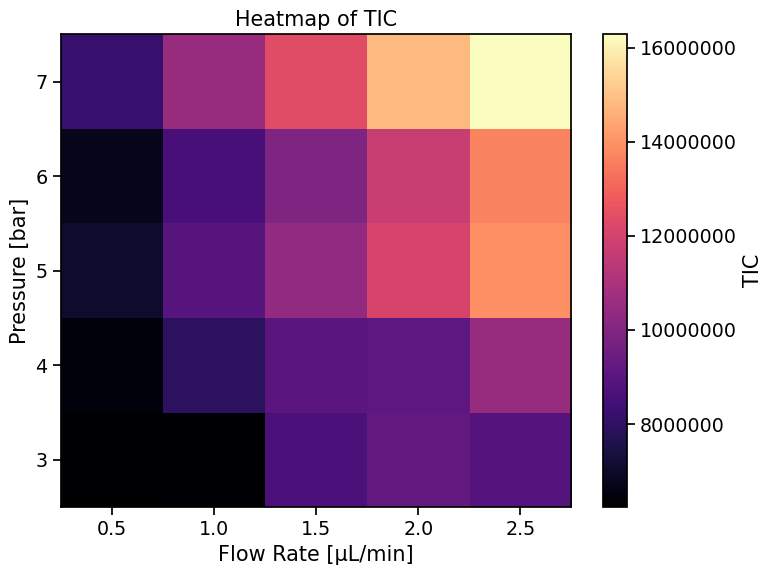

In [38]:
plot_tic_heatmap(mean_tic_df, PLOT_PATH / "mean_tic_heatmap.png")

In [11]:
mean_tic_df

,MeOH_85,MeOH_90,MeOH_93,MeOH_95,MeOH_98,MeOH_100,voltage_3,voltage_3.5,voltage_4,voltage_4.5,...,pressure_flow_rate_6-0.5,pressure_flow_rate_6-1,pressure_flow_rate_6-1.5,pressure_flow_rate_6-2,pressure_flow_rate_6-2.5,pressure_flow_rate_7-0.5,pressure_flow_rate_7-1,pressure_flow_rate_7-1.5,pressure_flow_rate_7-2,pressure_flow_rate_7-2.5
0,5486017.5,5815553.5,5466391.5,5362429.5,5269541.5,5258573.5,5651649.5,5583465.5,5670206.5,5695139.0,...,6721164.0,8525504.0,9918274.0,11715281.0,13692662.0,8179837.5,10532914.0,12326092.0,14824270.0,16282324.0


In [ ]:
plot_tic_heatmap

In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
from tqdm.notebook import tqdm

above_threshold = []

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in tqdm(np.array(samples_groups).flatten()):
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img[:, :, mzs_mask], axis=-1)

  img_list.append(img_with_res)

  mean_spectra = np.mean(img_with_res[seg], axis=0)

  above_threshold.append((mean_spectra >= 1))

  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
common_mzs_above_threshold = np.logical_and.reduce(above_threshold)

In [10]:
common_mzs_above_threshold.sum()

1145

In [21]:
from sklearn.manifold import TSNE


def plot_tsne(data, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create and fit the t-SNE model
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(data)

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend()
  plt.show()

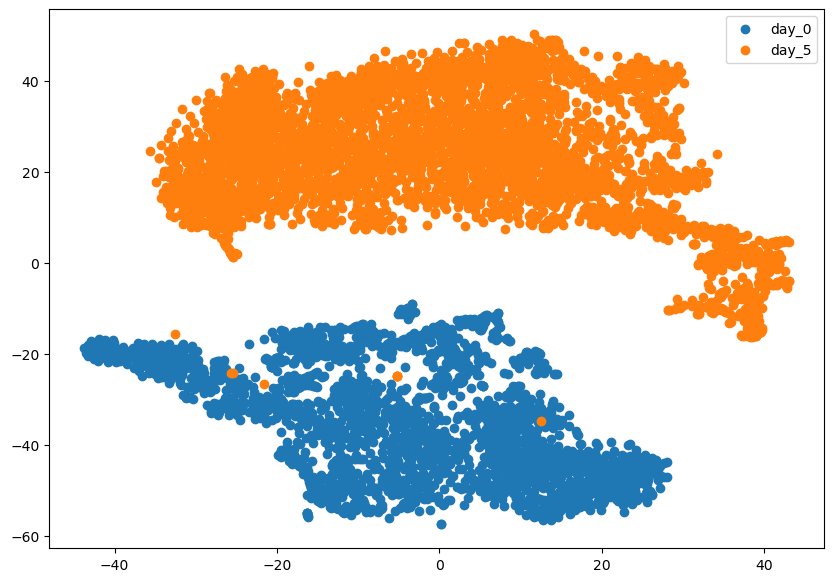

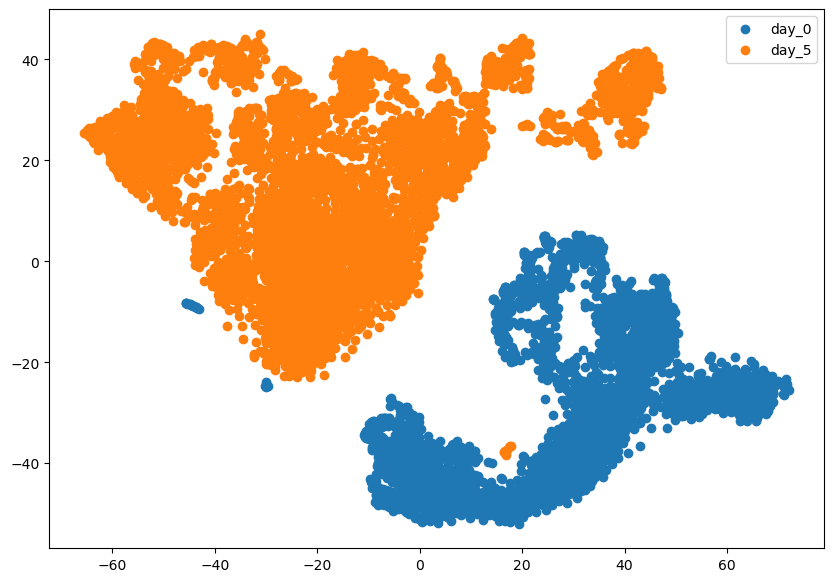

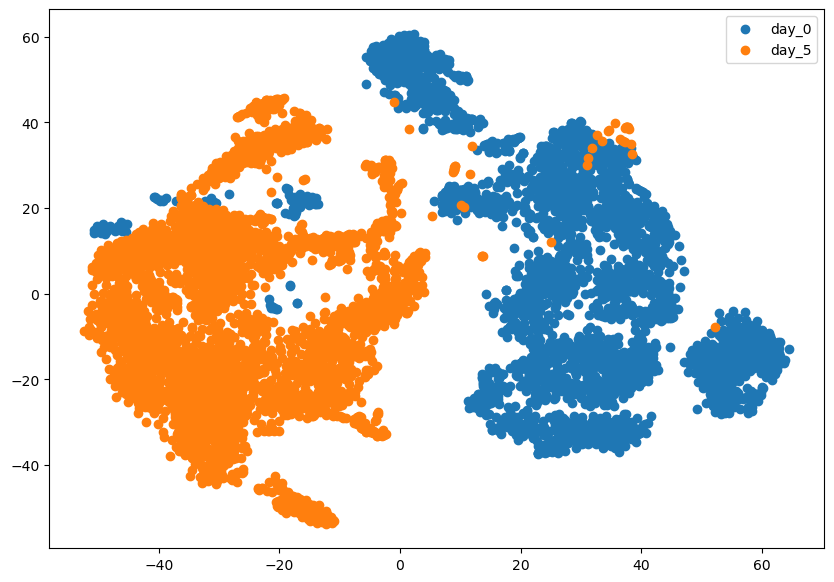

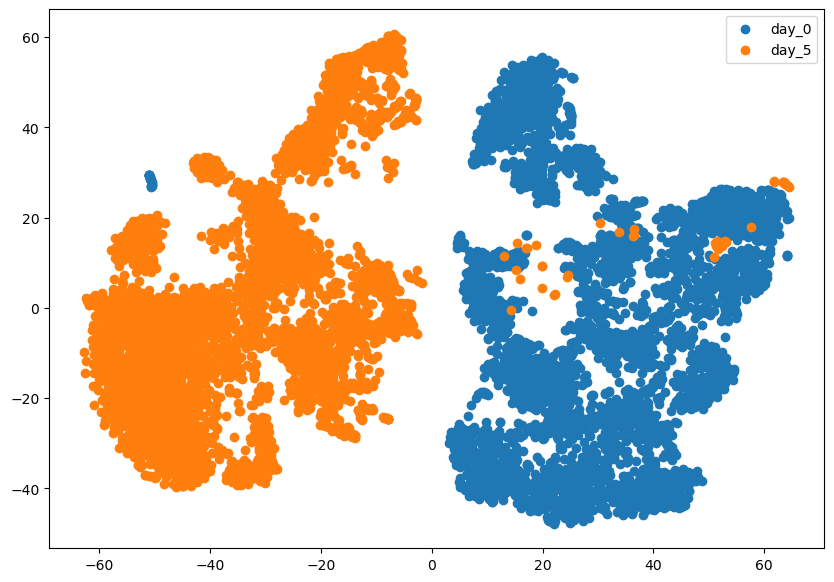

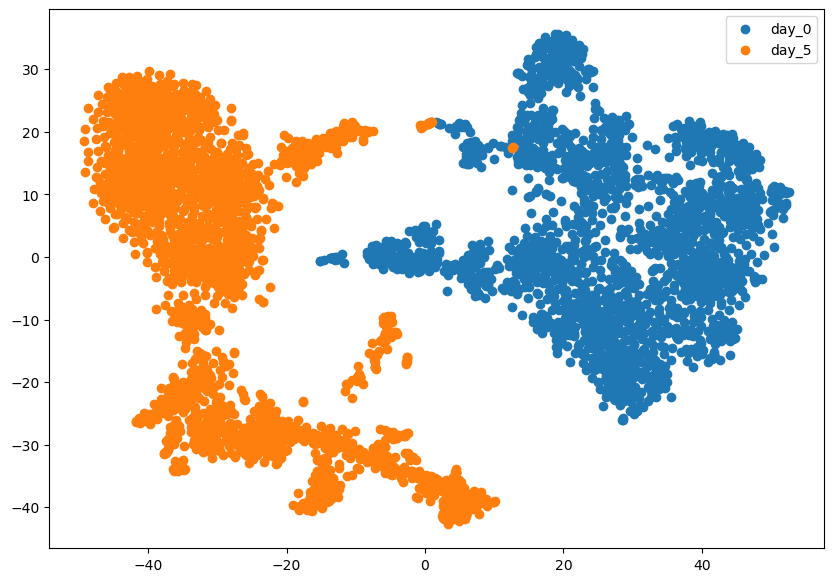

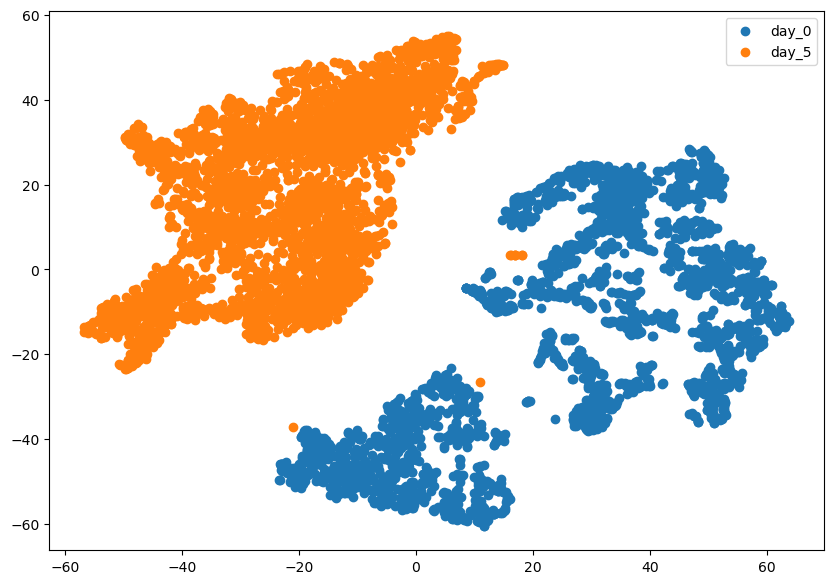

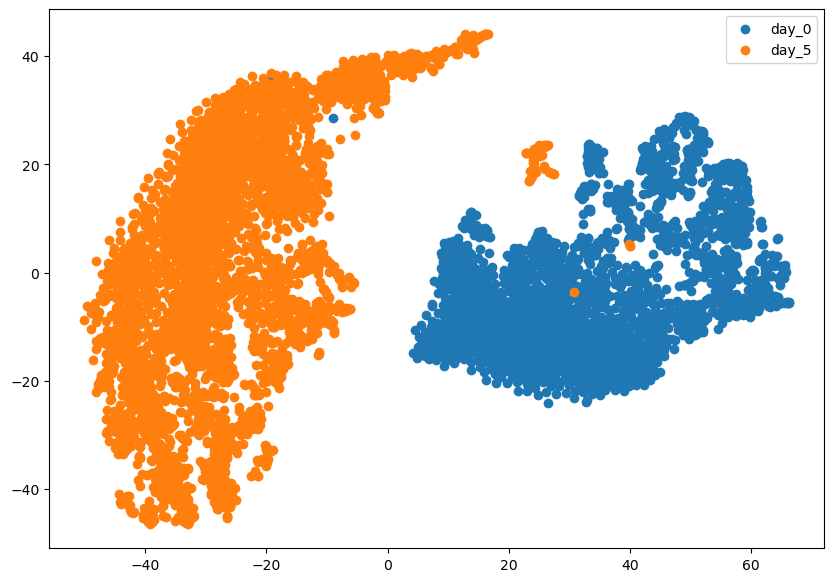

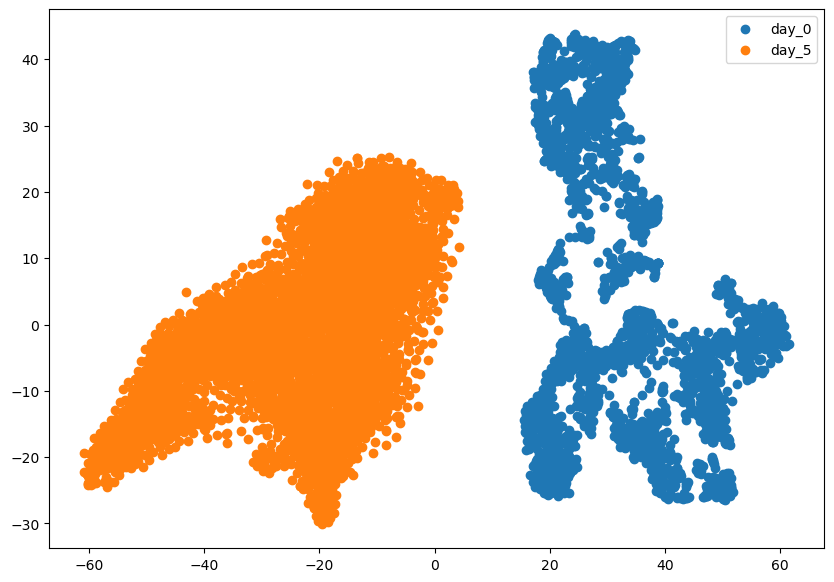

In [23]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [
              MinMaxScaler(clip=True).fit_transform(
                  img_list[idx][seg_list[idx]][:, common_mzs_above_threshold]
              ),
              MinMaxScaler(clip=True).fit_transform(
                  img_list[idx + 1][seg_list[idx +
                                             1]][:, common_mzs_above_threshold]
              )
          ]
      ),
      np.concatenate(
          [
              ["day_0"] * img_list[idx][seg_list[idx]].shape[0],
              ["day_5"] * img_list[idx + 1][seg_list[idx + 1]].shape[0]
          ]
      )
  )

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            MinMaxScaler(clip=True).fit_transform(
                img[seg][:, common_mzs_above_threshold]
            ) for img, seg in zip(img_list, seg_list)
        ]
    )
)

In [25]:
def plot_embeddings(embeddings, labels):
  tab20_cmap = plt.get_cmap('tab20')
  selected_colors = [tab20_cmap(i) for i in range(20)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for idx, label in enumerate(sorted(df_tsne['Label'].unique())):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'], subset['Component 2'], label=label,
        color=selected_colors[idx]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

In [28]:
def get_brain_id(name):
  return name.split("brain_")[1][0]

def get_treatment(name):
  return name.split("day_")[1].split("_")[1]

def get_day(name):
  return name.split("day_")[1][0]

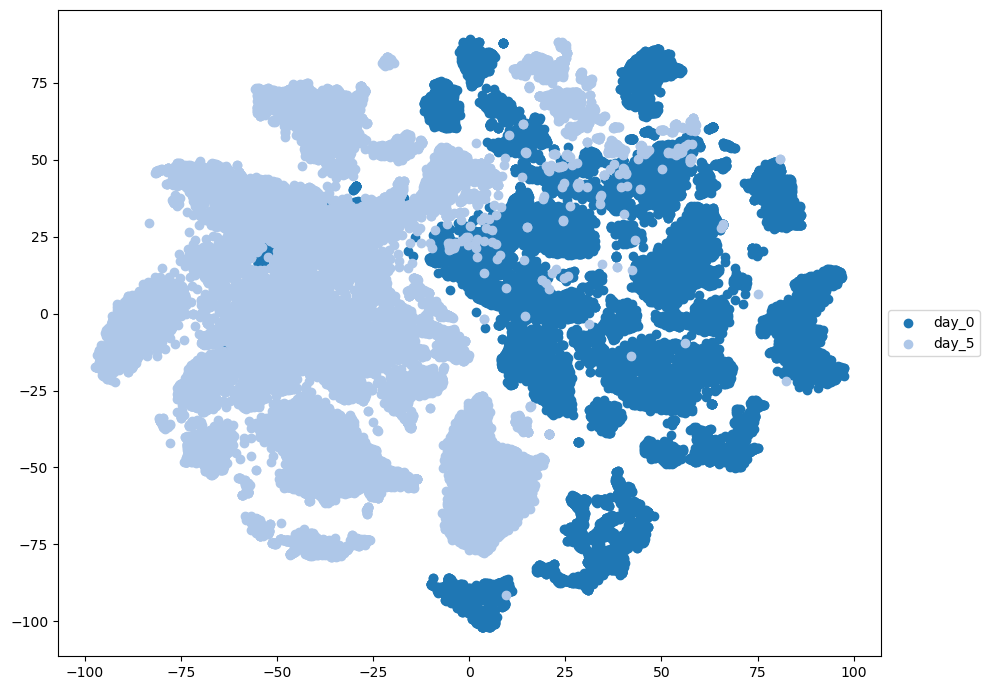

In [26]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            ["day_0"] * img[seg].shape[0] if idx % 2 == 0 else ["day_5"] *
            img[seg].shape[0]
            for idx, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

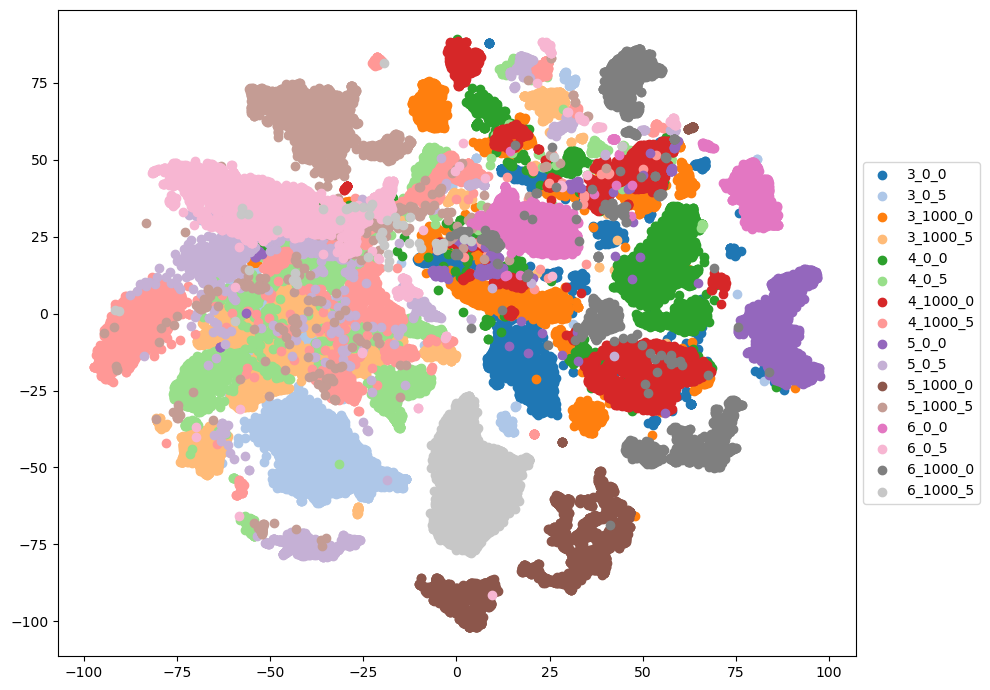

In [29]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_brain_id(sample)}_{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

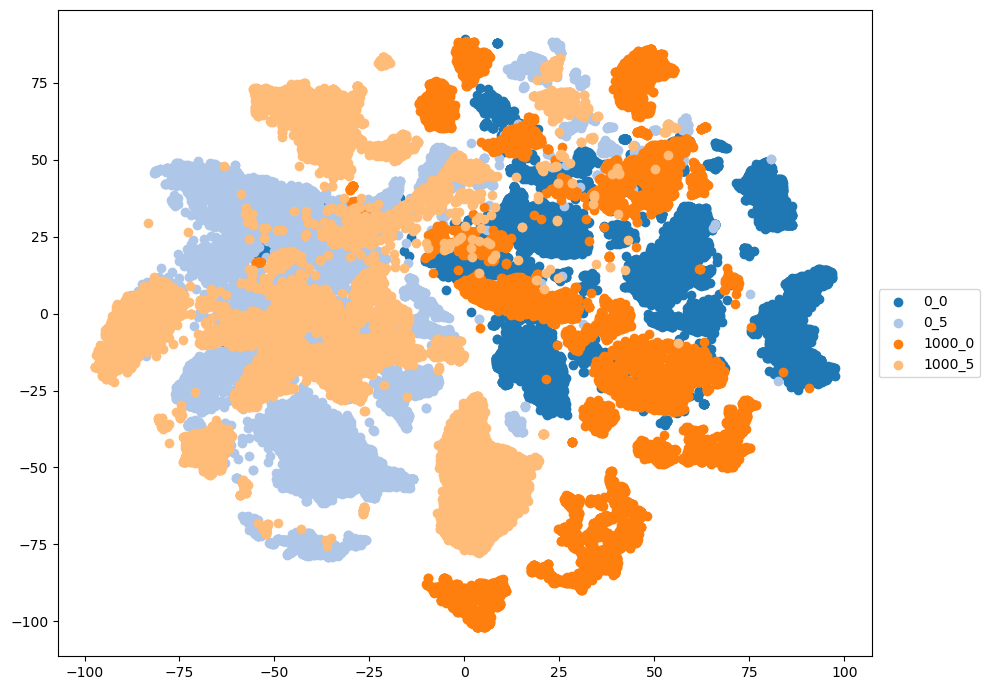

In [30]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

In [44]:
a.data_max_

array([47.80165952, 66.82387495, 91.39200735, ..., 41.57925424,
       33.26368788, 32.84147972])

In [45]:
def global_minmax_normalize(vectors):
    # Compute global min and max
    global_min = vectors.min()
    global_max = vectors.max()
    
    # Apply global min-max normalization
    normalized_vectors = (vectors - global_min) / (global_max - global_min)
    
    return normalized_vectors


In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(
    np.concatenate(
        [
            global_minmax_normalize(
                img[seg][:, common_mzs_above_threshold]
            ) for img, seg in zip(img_list, seg_list)
        ]
    )
)

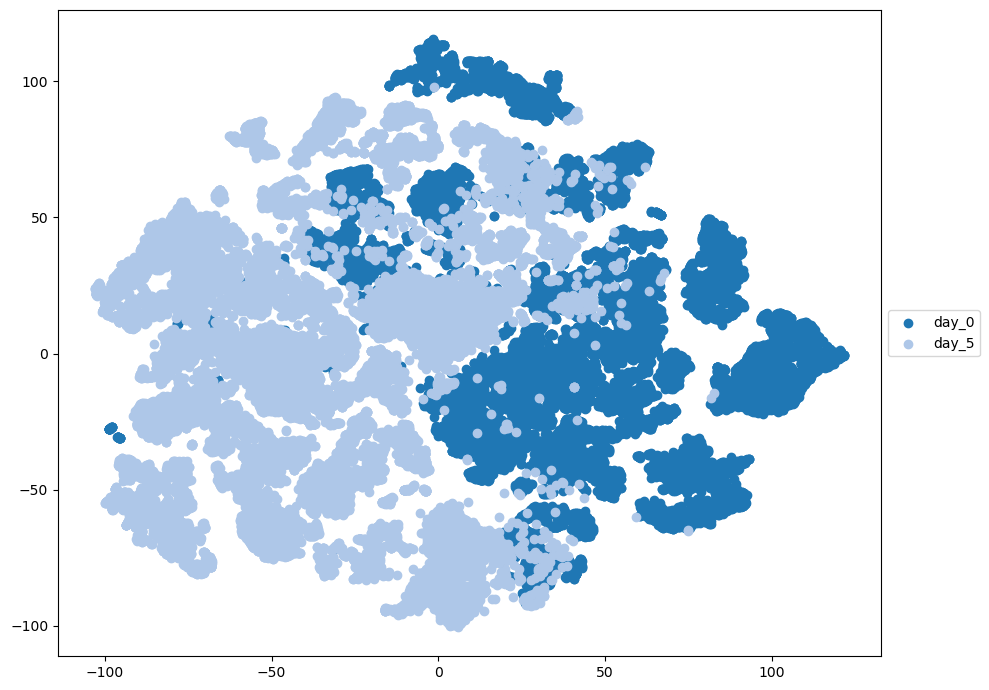

In [47]:
plot_embeddings(
    tsne_result,
    np.concatenate(
        [
            ["day_0"] * img[seg].shape[0] if idx % 2 == 0 else ["day_5"] *
            img[seg].shape[0]
            for idx, (img, seg) in enumerate(zip(img_list, seg_list))
        ]
    )
)

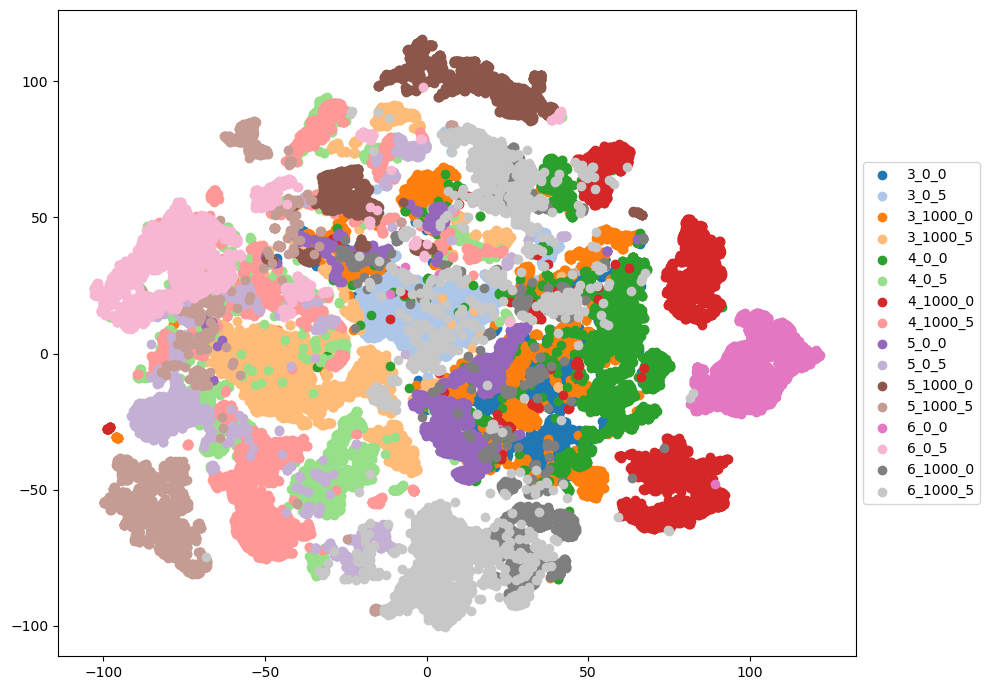

In [48]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_brain_id(sample)}_{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

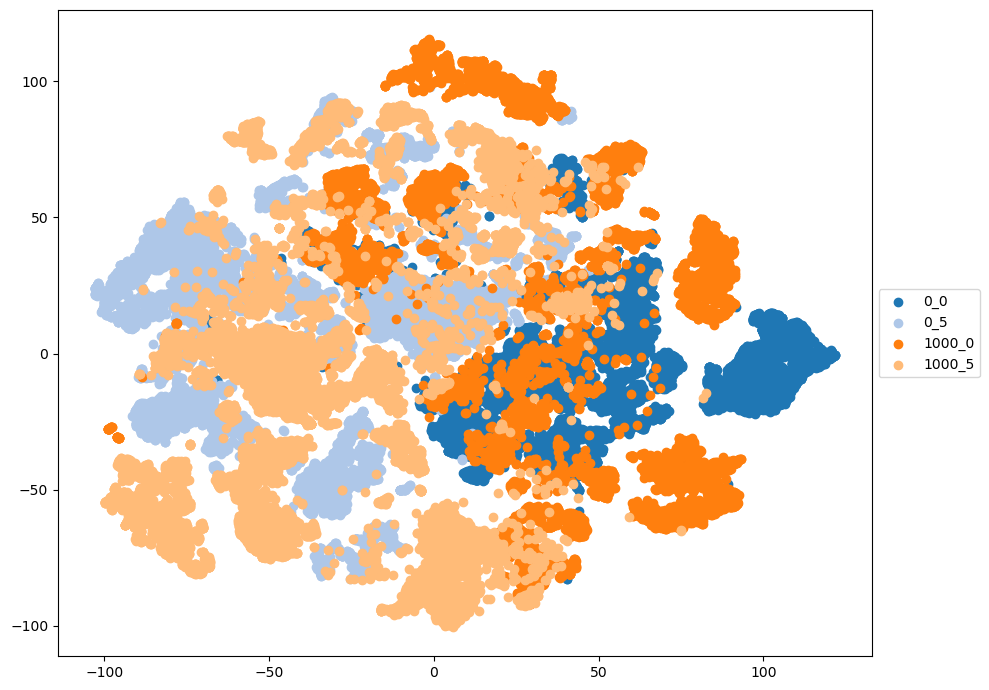

In [49]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

In [7]:
from sklearn.cluster import SpectralClustering

def preprocess_images(images, segs):
    flattened_images = []
    pixel_indices = []
    shapes = []
    
    for img, seg in tqdm(zip(images, segs), total=len(images), desc="Preprocessing Images"):
        # Extract only the pixels within the segmented area
        segmented_pixels = img[seg]
        
        # Check for zero variance pixels
        pixel_variances = np.var(segmented_pixels, axis=1)
        zero_variance_pixels = np.sum(pixel_variances == 0)
        if zero_variance_pixels > 0:
            print(f"Found {zero_variance_pixels} pixels with zero variance in one of the images.")
        
        flattened_images.append(segmented_pixels)
        
        # Store the original shape and the indices of segmented pixels
        shapes.append(img.shape[:2])
        pixel_indices.append(np.where(seg.reshape(-1)))
    
    combined_data = np.vstack(flattened_images)
    return combined_data, shapes, pixel_indices

def compute_correlation_matrix(data):
    correlation_matrix = np.corrcoef(data, rowvar=False)
    
    # Check for NaNs in the correlation matrix
    if np.isnan(correlation_matrix).any():
        print("NaNs found in the correlation matrix.")
        nan_indices = np.where(np.isnan(correlation_matrix))
        print(f"NaN indices: {nan_indices}")
        
        # Debugging: Inspect data causing NaNs
        rows_with_nan = np.unique(nan_indices[0])
        print(f"Rows with NaNs: {rows_with_nan}")
        for row in rows_with_nan:
            print(f"Data causing NaNs (row {row}): {data[:, row]}")
    
    # Replace NaNs with zeros
    correlation_matrix = np.nan_to_num(correlation_matrix)
    return correlation_matrix

def cluster_pixels_based_on_correlation(images, segs, n_clusters=3):
    combined_data, shapes, pixel_indices = preprocess_images(images, segs)
    
    # Display progress during correlation matrix computation
    print("Computing correlation matrix...")
    correlation_matrix = compute_correlation_matrix(combined_data)
    
    # Ensure there are no NaNs after replacing them
    if np.isnan(correlation_matrix).any():
        raise ValueError("NaNs are still present in the correlation matrix after replacement.")
    
    # Display progress during spectral clustering
    print("Performing spectral clustering...")
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral_clustering.fit_predict(correlation_matrix)
    
    # Initialize an empty list to store the cluster maps
    cluster_maps = []
    start = 0
    
    # Map the clustered labels back to the original image shapes
    for shape, indices in tqdm(zip(shapes, pixel_indices), total=len(shapes), desc="Mapping Clusters"):
        cluster_map = np.zeros(shape, dtype=int) - 1  # Use -1 for background
        size = len(indices[0])
        cluster_map[np.unravel_index(indices, shape)] = labels[start:start + size]
        cluster_maps.append(cluster_map)
        start += size
    
    return cluster_maps

cluster_maps = cluster_pixels_based_on_correlation(img_list, seg_list, n_clusters=3)

# Example to visualize the cluster maps for each image
for i, cluster_map in enumerate(cluster_maps):
    plt.figure()
    plt.title(f'Cluster Map for Image {i+1}')
    plt.imshow(cluster_map, cmap='viridis')
    plt.colorbar()
    plt.show()

Preprocessing Images:   0%|          | 0/16 [00:00<?, ?it/s]

Preprocessing Images:  81%|████████▏ | 13/16 [10:21<03:03, 61.31s/it]

: 

In [51]:
means = []

for img, seg in zip(img_list, seg_list):
  
  mean_spectra = np.mean(img[seg], axis=0)

  means.append(mean_spectra)

# Number of arrays in the list
n = len(means)

# Initialize a matrix to store correlation coefficients
correlation_matrix = np.zeros((n, n))

# Calculate correlations
for i in range(n):
    for j in range(n):
        if i != j:
            correlation_matrix[i, j] = np.corrcoef(means[i], means[j])[0, 1]
        else:
            correlation_matrix[i, j] = 1.0  # Correlation with itself

# Display the correlation matrix
print(correlation_matrix)

[[1.         0.86659139 0.93161122 0.68983074 0.96187702 0.78224238
  0.95251501 0.75606602 0.92632014 0.78874882 0.88403435 0.69258344
  0.86656917 0.84188005 0.90438071 0.79167695]
 [0.86659139 1.         0.86885583 0.84227861 0.86896656 0.90166393
  0.86884277 0.87476718 0.82902379 0.8910902  0.78087685 0.78182077
  0.75204279 0.90301783 0.87873801 0.84699279]
 [0.93161122 0.86885583 1.         0.79279643 0.95134166 0.84708604
  0.95983134 0.81744933 0.92314366 0.80673205 0.87179897 0.71810818
  0.83333555 0.88677683 0.90631671 0.79729712]
 [0.68983074 0.84227861 0.79279643 1.         0.70816542 0.94346445
  0.7348291  0.94024246 0.76039519 0.88469129 0.64631503 0.81917922
  0.66775876 0.91588584 0.83785778 0.85421203]
 [0.96187702 0.86896656 0.95134166 0.70816542 1.         0.75712661
  0.96947933 0.74036127 0.94279027 0.76280347 0.90556462 0.6252175
  0.89041794 0.83109129 0.89562751 0.74341954]
 [0.78224238 0.90166393 0.84708604 0.94346445 0.75712661 1.
  0.79176718 0.96829767 0.

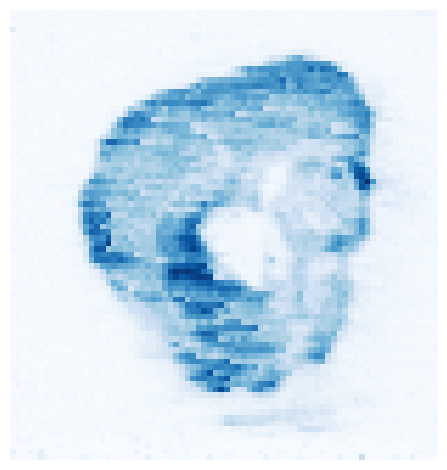

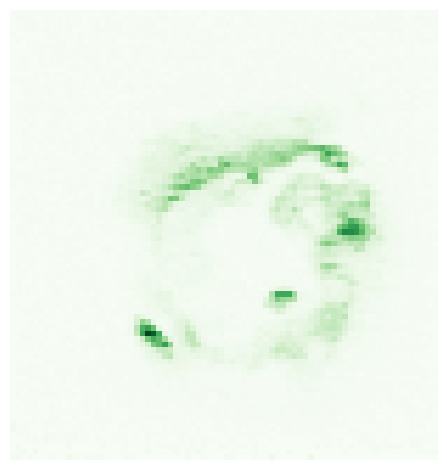

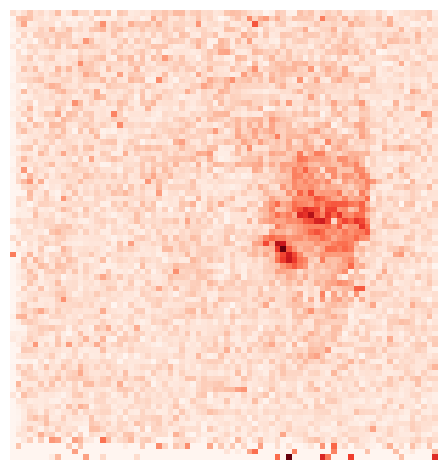

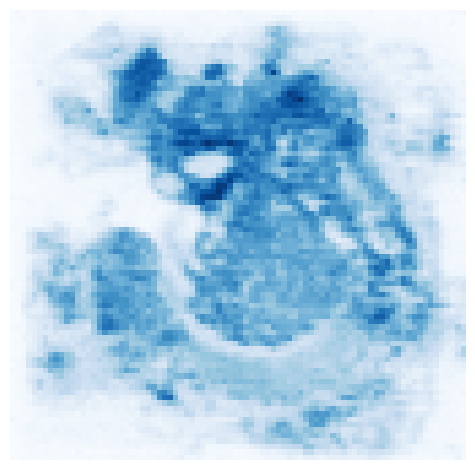

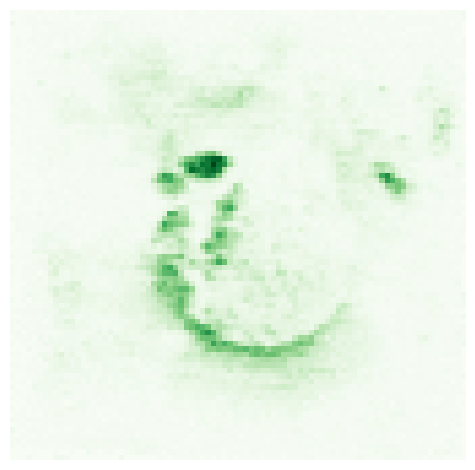

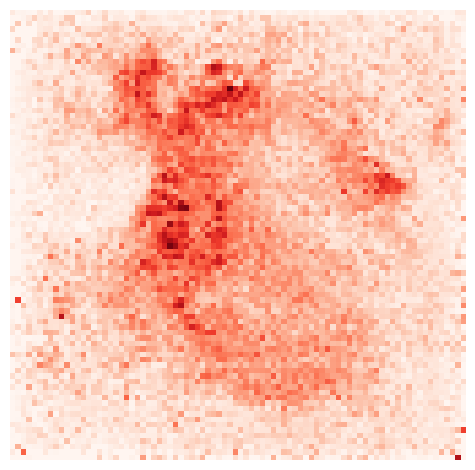

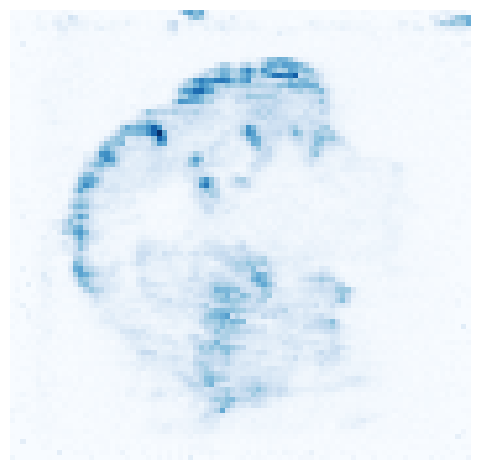

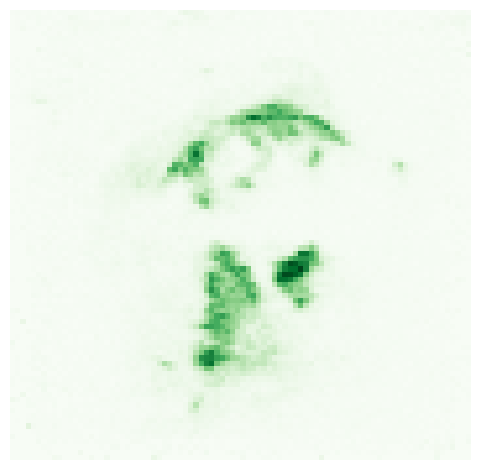

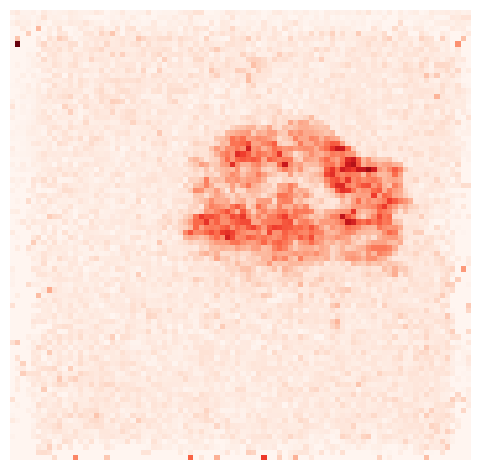

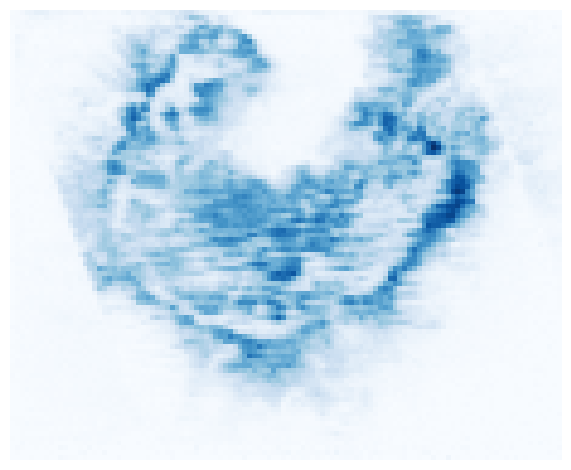

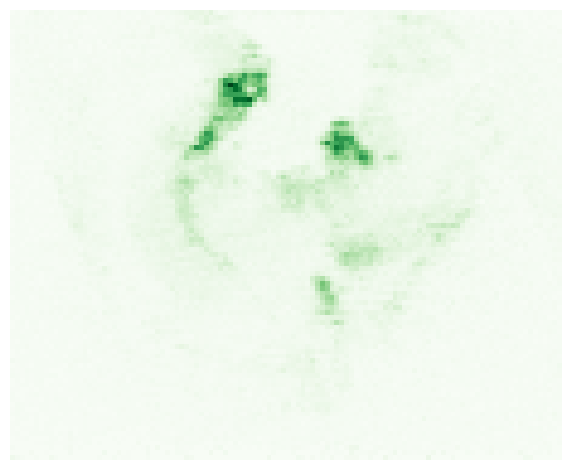

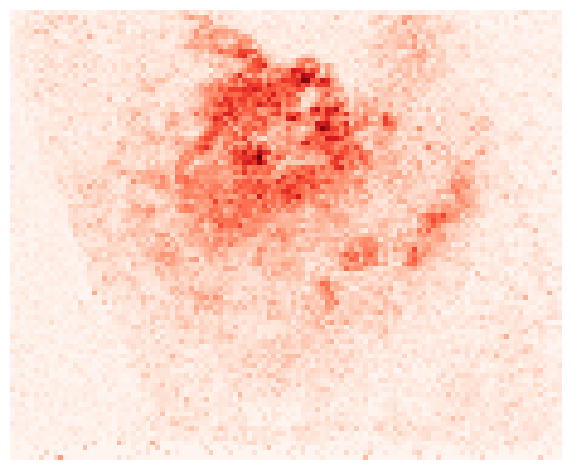

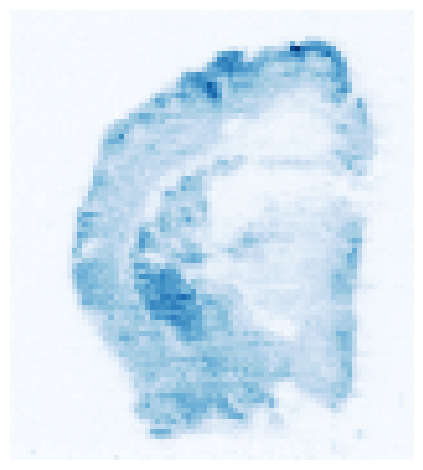

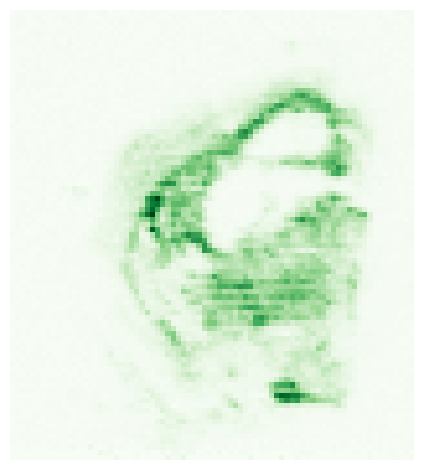

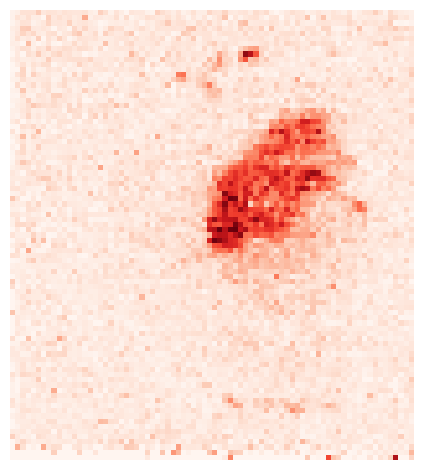

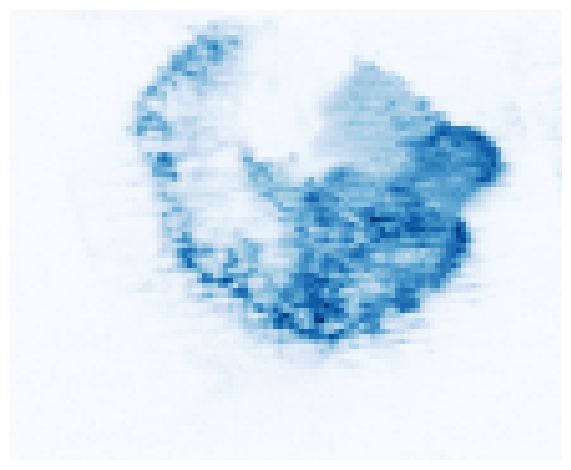

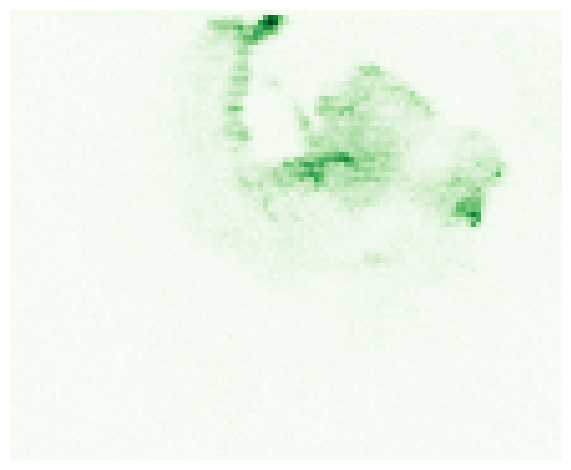

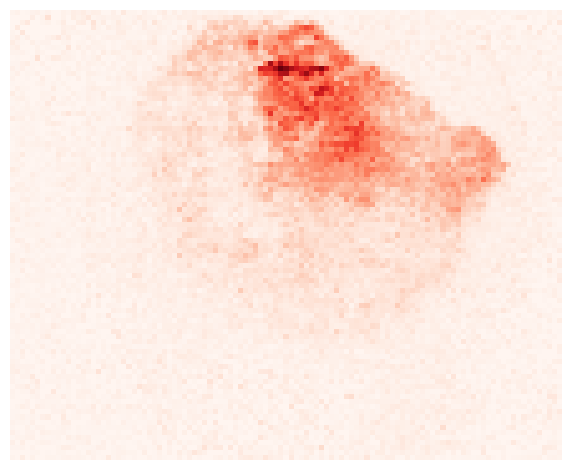

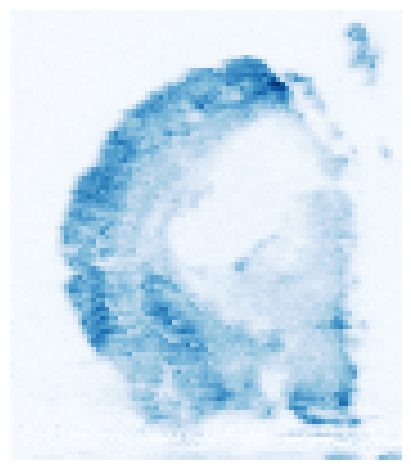

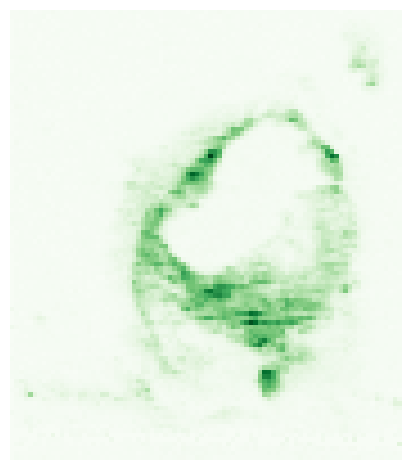

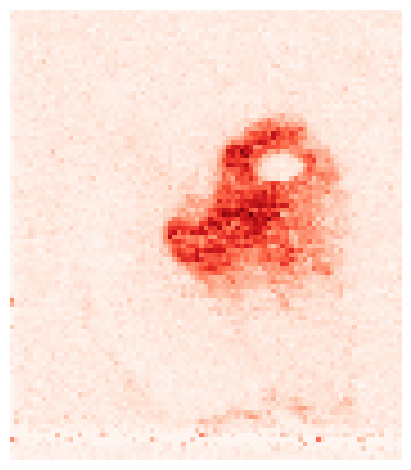

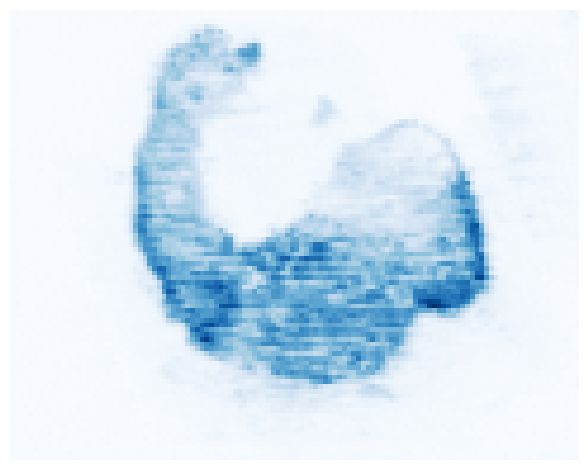

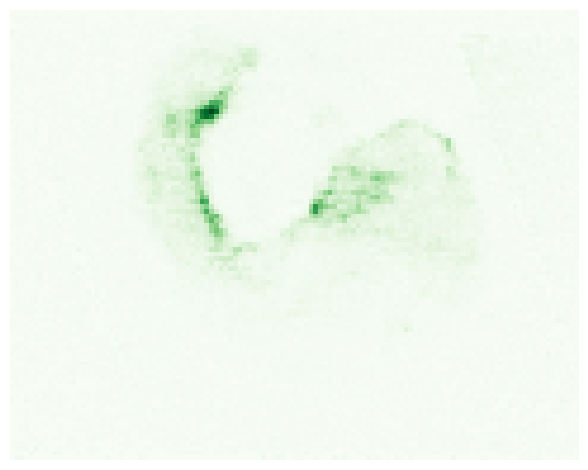

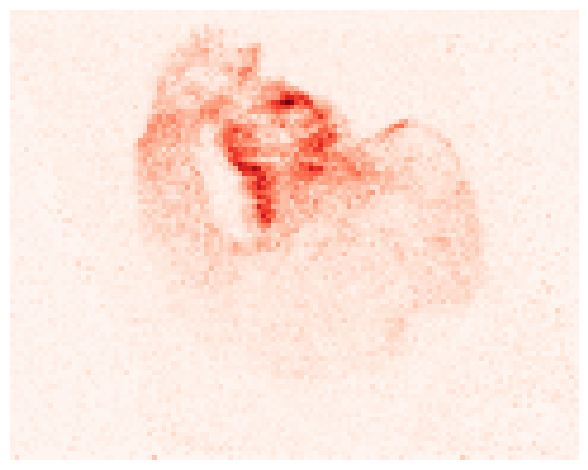

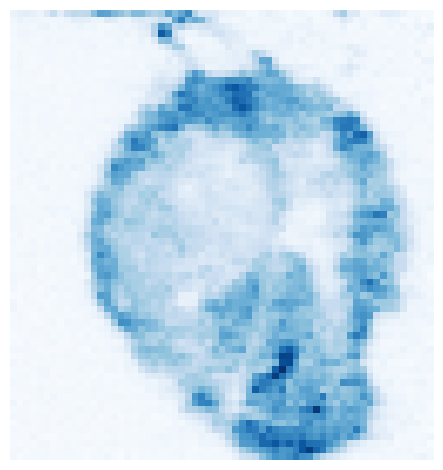

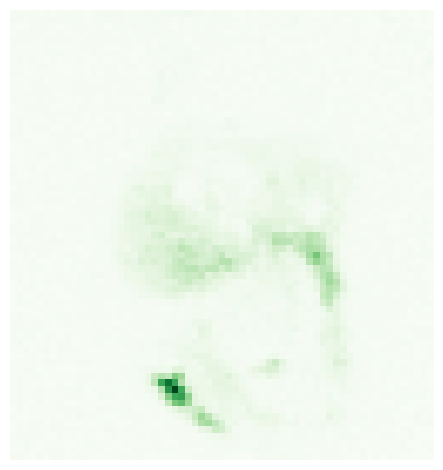

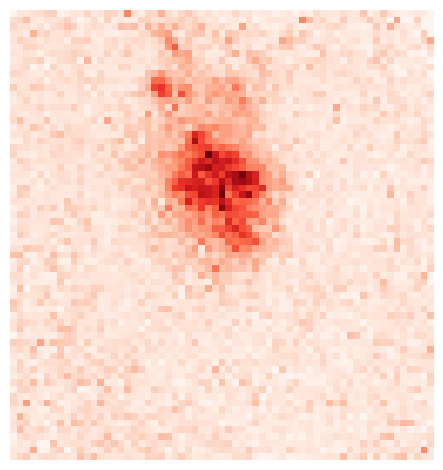

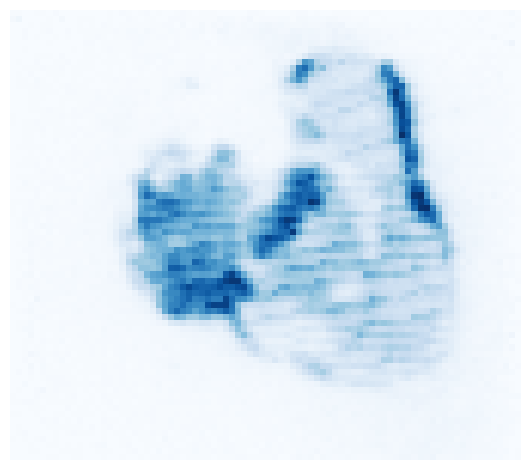

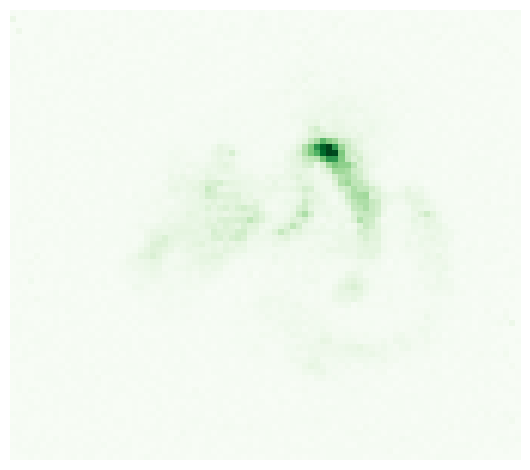

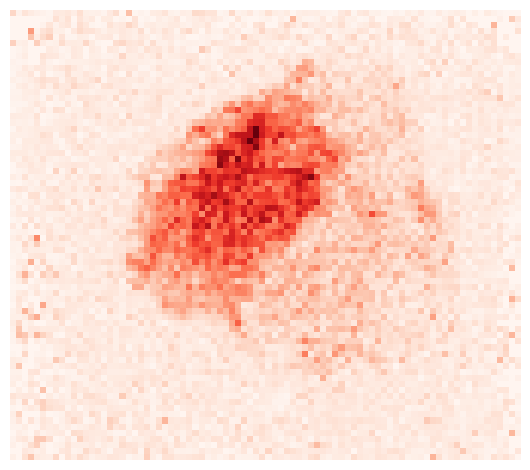

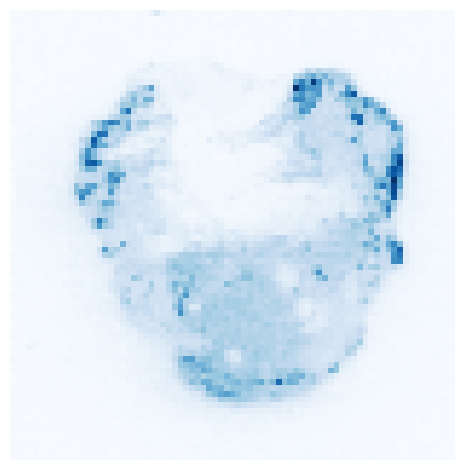

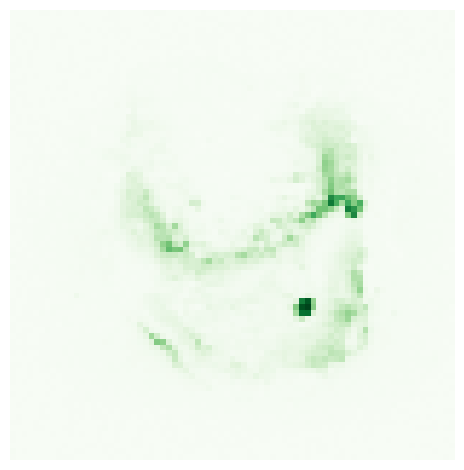

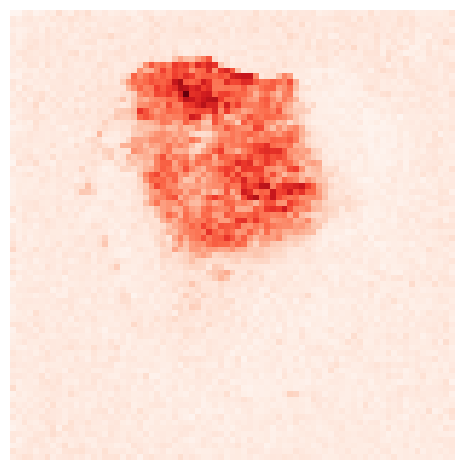

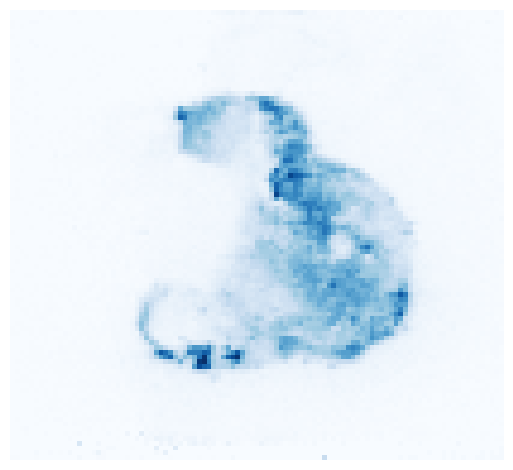

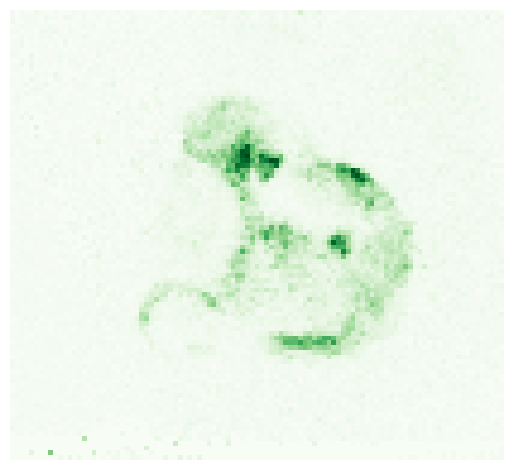

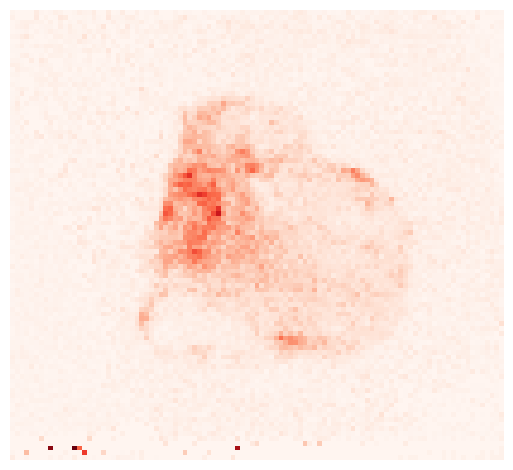

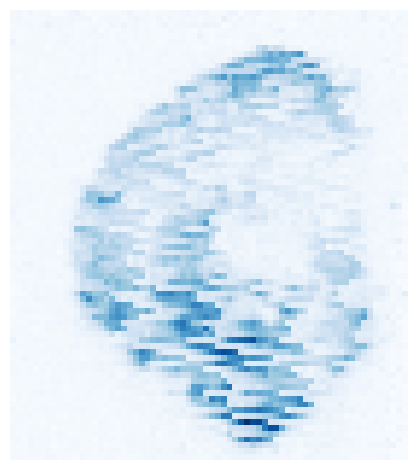

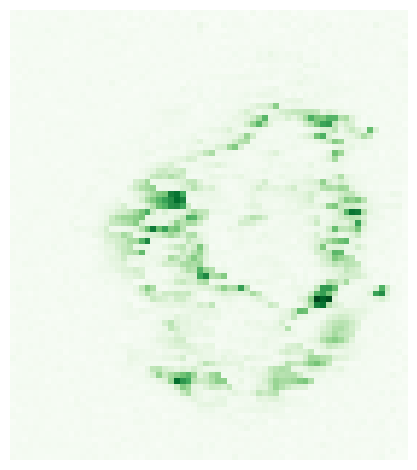

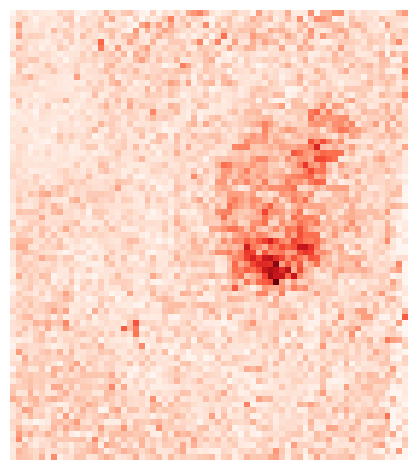

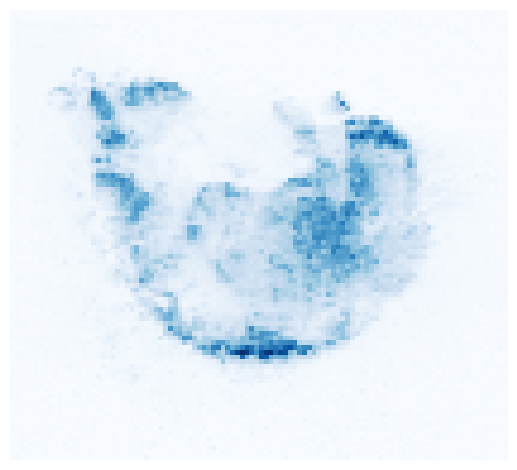

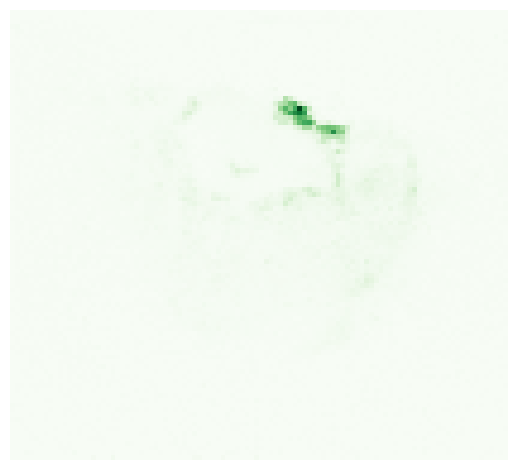

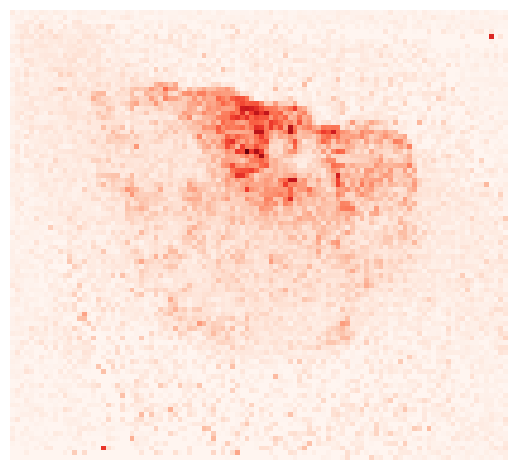

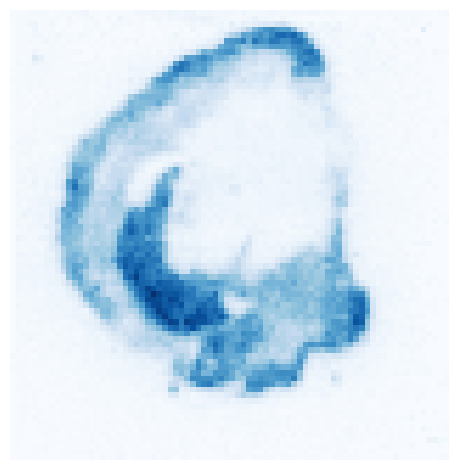

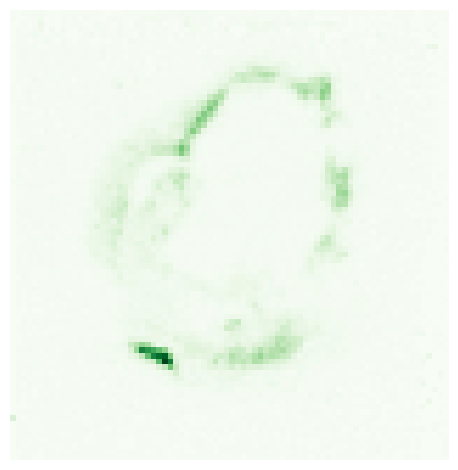

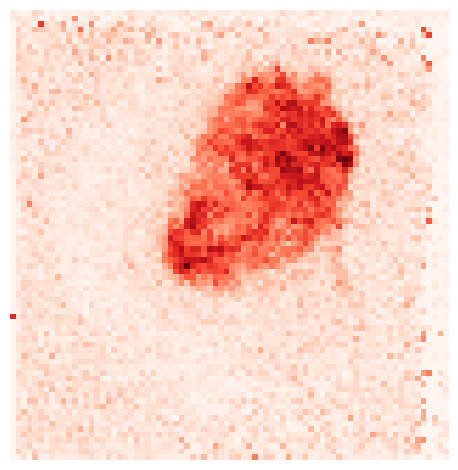

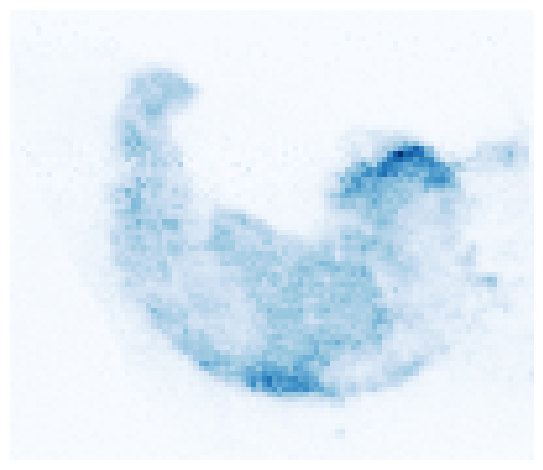

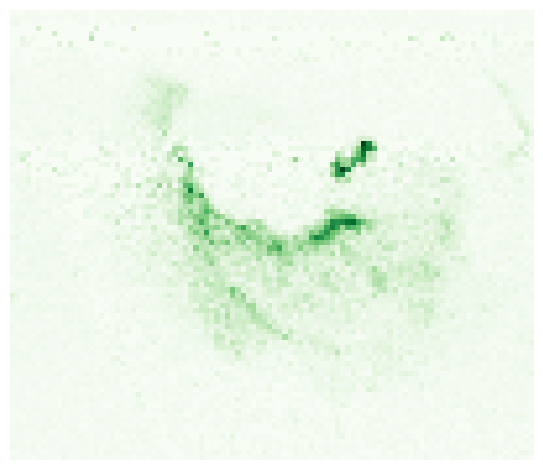

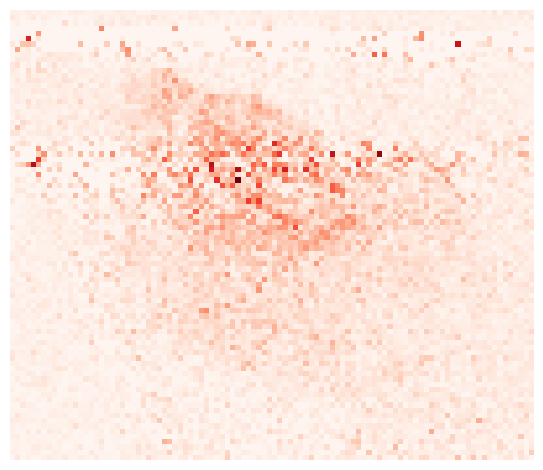

In [31]:
# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

mzs_filter = gray_matter_mzs_filter | tumour_mzs_filter | white_matter_mzs_filter

for img in img_list:
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    plot_img = img[:, :, loop_filter].mean(axis=-1)
    plt.imshow(plot_img, cmap=color_map)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

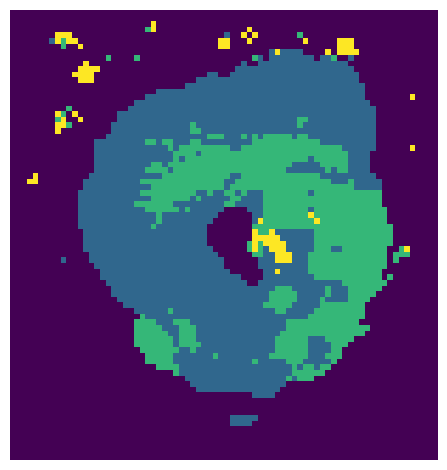

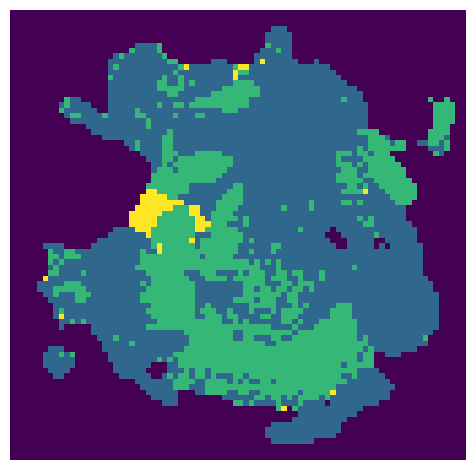

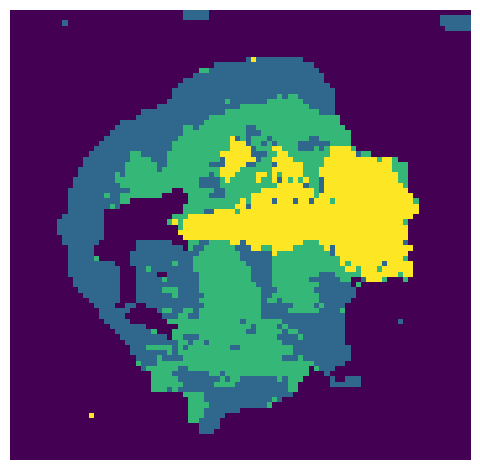

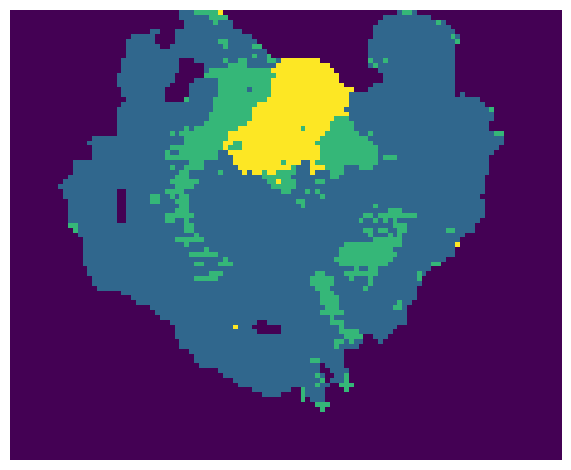

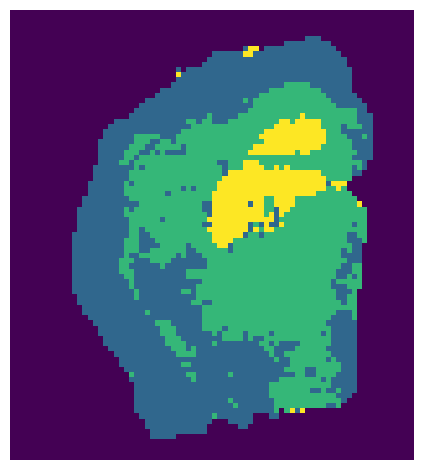

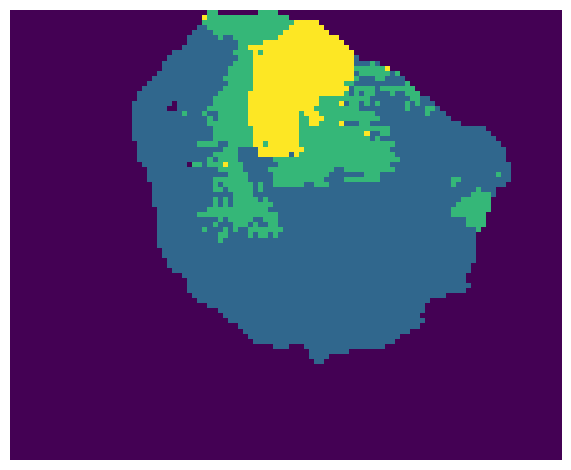

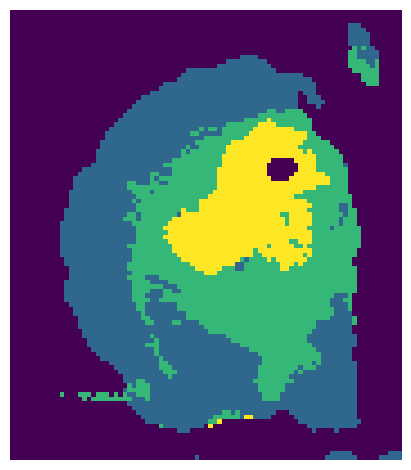

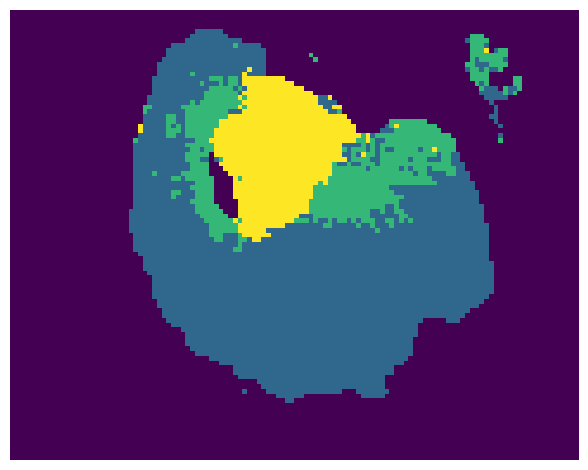

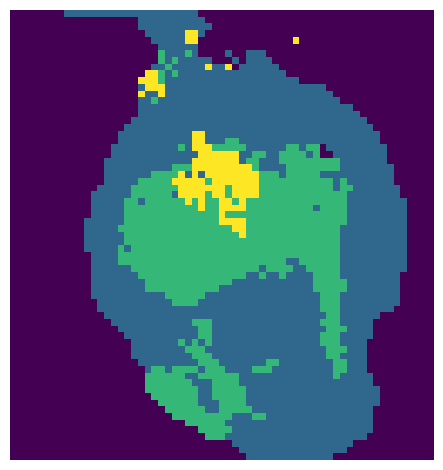

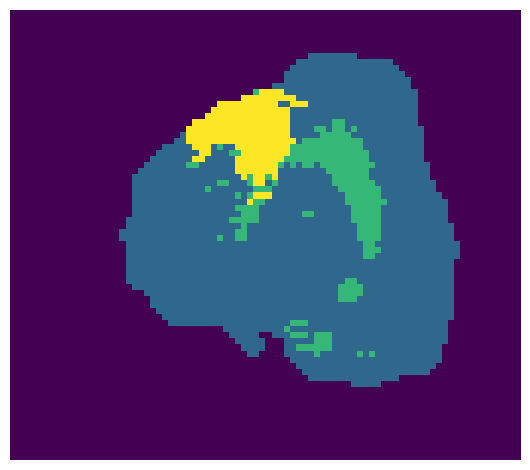

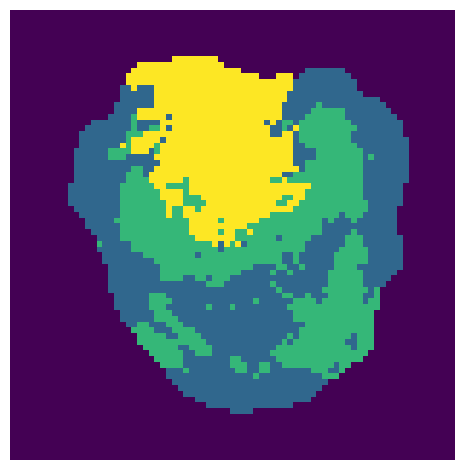

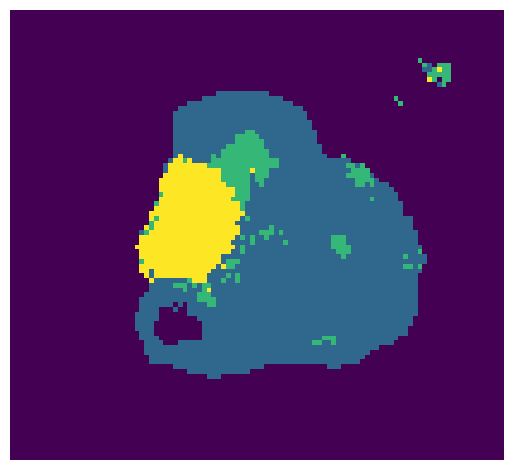

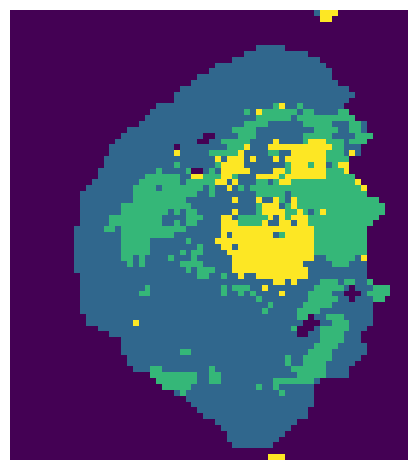

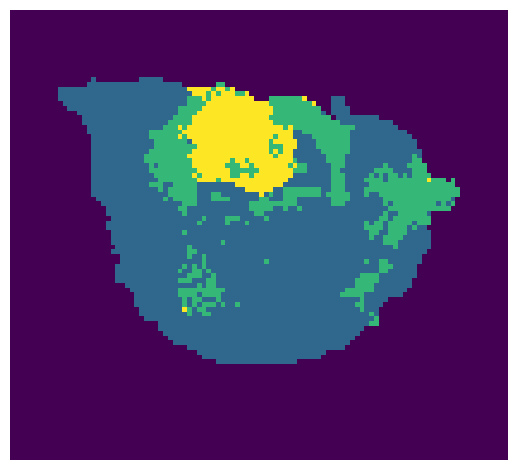

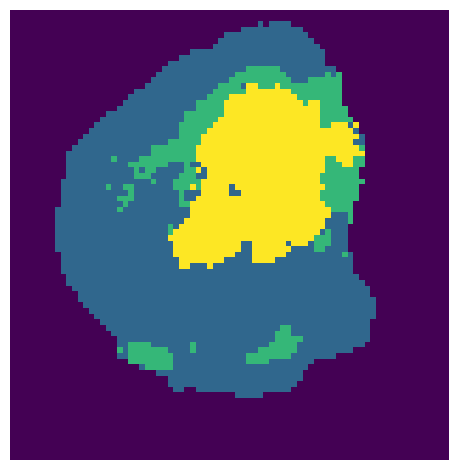

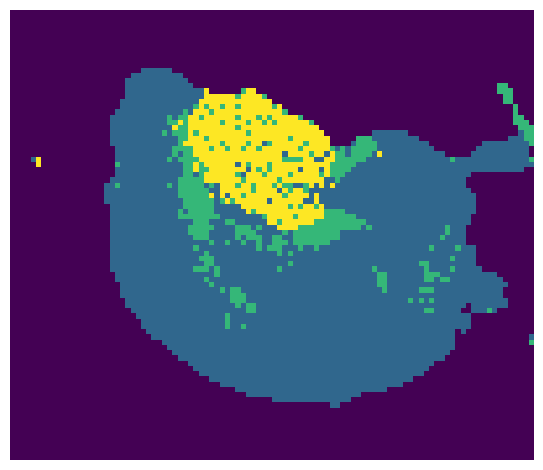

In [50]:
for img, seg in zip(img_list, seg_list):

  gray_matter_img = img[:, :, gray_matter_mzs_filter].mean(axis=-1)
  white_matter_img = img[:, :, white_matter_mzs_filter].mean(axis=-1)
  tumour_img = img[:, :, tumour_mzs_filter].mean(axis=-1)

  #gray_matter_img = MinMaxScaler().fit_transform(gray_matter_img.reshape(-1, 1)).reshape(gray_matter_img.shape)
  #white_matter_img = MinMaxScaler().fit_transform(white_matter_img.reshape(-1, 1)).reshape(white_matter_img.shape)
  #tumour_img = MinMaxScaler().fit_transform(tumour_img.reshape(-1, 1)).reshape(tumour_img.shape)

  cluster_labels = np.argmax(np.stack([gray_matter_img, white_matter_img, tumour_img]), axis=0)
  cluster_labels += 1
  cluster_labels[~seg] = 0
  
  plt.imshow(cluster_labels)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [ ]:
def minmax_normalize_per_channel_sklearn(image):
    # Initialize an array to hold the normalized image
    normalized_image = np.zeros_like(image, dtype=np.float32)
    
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()
    
    # Iterate over each channel
    for c in range(image.shape[2]):
        # Reshape the channel to a 2D array (pixels x 1)
        channel = image[:, :, c].reshape(-1, 1)
        
        # Apply MinMaxScaler to the channel
        normalized_channel = scaler.fit_transform(channel)
        
        # Reshape the normalized channel back to its original shape
        normalized_image[:, :, c] = normalized_channel.reshape(image.shape[0], image.shape[1])
    
    return normalized_image

In [17]:
filtered_mzs = mzs[np.logical_and.reduce(above_threshold)]

gray_matter_mzs_filter = (
    (filtered_mzs >= 600.51 - 0.025) & (filtered_mzs <= 600.51 + 0.025)
)

tumour_mzs_filter = (
    (filtered_mzs >= 682.64 - 0.025) & (filtered_mzs <= 682.64 + 0.025)
)

white_matter_mzs_filter = (
    (filtered_mzs >= 888.62 - 0.025) & (filtered_mzs <= 888.62 + 0.025)
)

gray_matter_mzs_filter.sum(), tumour_mzs_filter.sum(
), white_matter_mzs_filter.sum()

(4, 1, 4)

In [18]:
filtered_mzs.shape

(1145,)

In [ ]:
plt.imshow(seg)
plt.show()

In [ ]:
gaussian_sigma = 1.0
n_clusters = 4

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  img[~seg] = 0

  img_smoothed = ndimage.gaussian_filter(img, sigma=gaussian_sigma)
  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img_smoothed[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_list.append(img_with_res)